In [84]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

In [85]:
# fetch dataset
data = fetch_ucirepo(id=144)

# extract data and labels 
X = data.data.features
y = data.data.targets

# extract other important information
metadata = data.metadata
variables = data.variables

In [86]:
# save data locally if not already done
df = pd.concat([X, y], axis=1)
if not os.path.exists("../data/raw_data.csv"):
    df.to_csv('../data/raw_data.csv', index=False)

We are working with the following attributes:

In [87]:
print(variables[["description", "units", "type"]])

                                          description   units         type
0                 Status of existing checking account    None  Categorical
1                                            Duration  months      Integer
2                                      Credit history    None  Categorical
3                                             Purpose    None  Categorical
4                                       Credit amount    None      Integer
5                               Savings account/bonds    None  Categorical
6                            Present employment since    None  Categorical
7   Installment rate in percentage of disposable i...    None      Integer
8                             Personal status and sex    None  Categorical
9                          Other debtors / guarantors    None  Categorical
10                            Present residence since    None      Integer
11                                           Property    None  Categorical
12                       

This provides valuable information about what the various attributes of the dataset represent and will help us determine how we will encode the various categorical variables:

In [88]:
print(metadata.additional_info.variable_info)

Attribute 1:  (qualitative)      
 Status of existing checking account
             A11 :      ... <    0 DM
	       A12 : 0 <= ... <  200 DM
	       A13 :      ... >= 200 DM / salary assignments for at least 1 year
               A14 : no checking account

Attribute 2:  (numerical)
	      Duration in month

Attribute 3:  (qualitative)
	      Credit history
	      A30 : no credits taken/ all credits paid back duly
              A31 : all credits at this bank paid back duly
	      A32 : existing credits paid back duly till now
              A33 : delay in paying off in the past
	      A34 : critical account/  other credits existing (not at this bank)

Attribute 4:  (qualitative)
	      Purpose
	      A40 : car (new)
	      A41 : car (used)
	      A42 : furniture/equipment
	      A43 : radio/television
	      A44 : domestic appliances
	      A45 : repairs
	      A46 : education
	      A47 : (vacation - does not exist?)
	      A48 : retraining
	      A49 : business
	      A410 : others

A

In [89]:
print(f"The data has {metadata.has_missing_values} missing values. Therefore, we will not have to impute or remove these values.")

The data has no missing values. Therefore, we will not have to impute or remove these values.


First, we will see if we need to address (remove or handle) outliers in the dataset. In order to do this, we will visualize the numerical attributes using boxplots.

In [90]:
# create mask to track all outliers
mask = pd.Series(True, index=df.index)

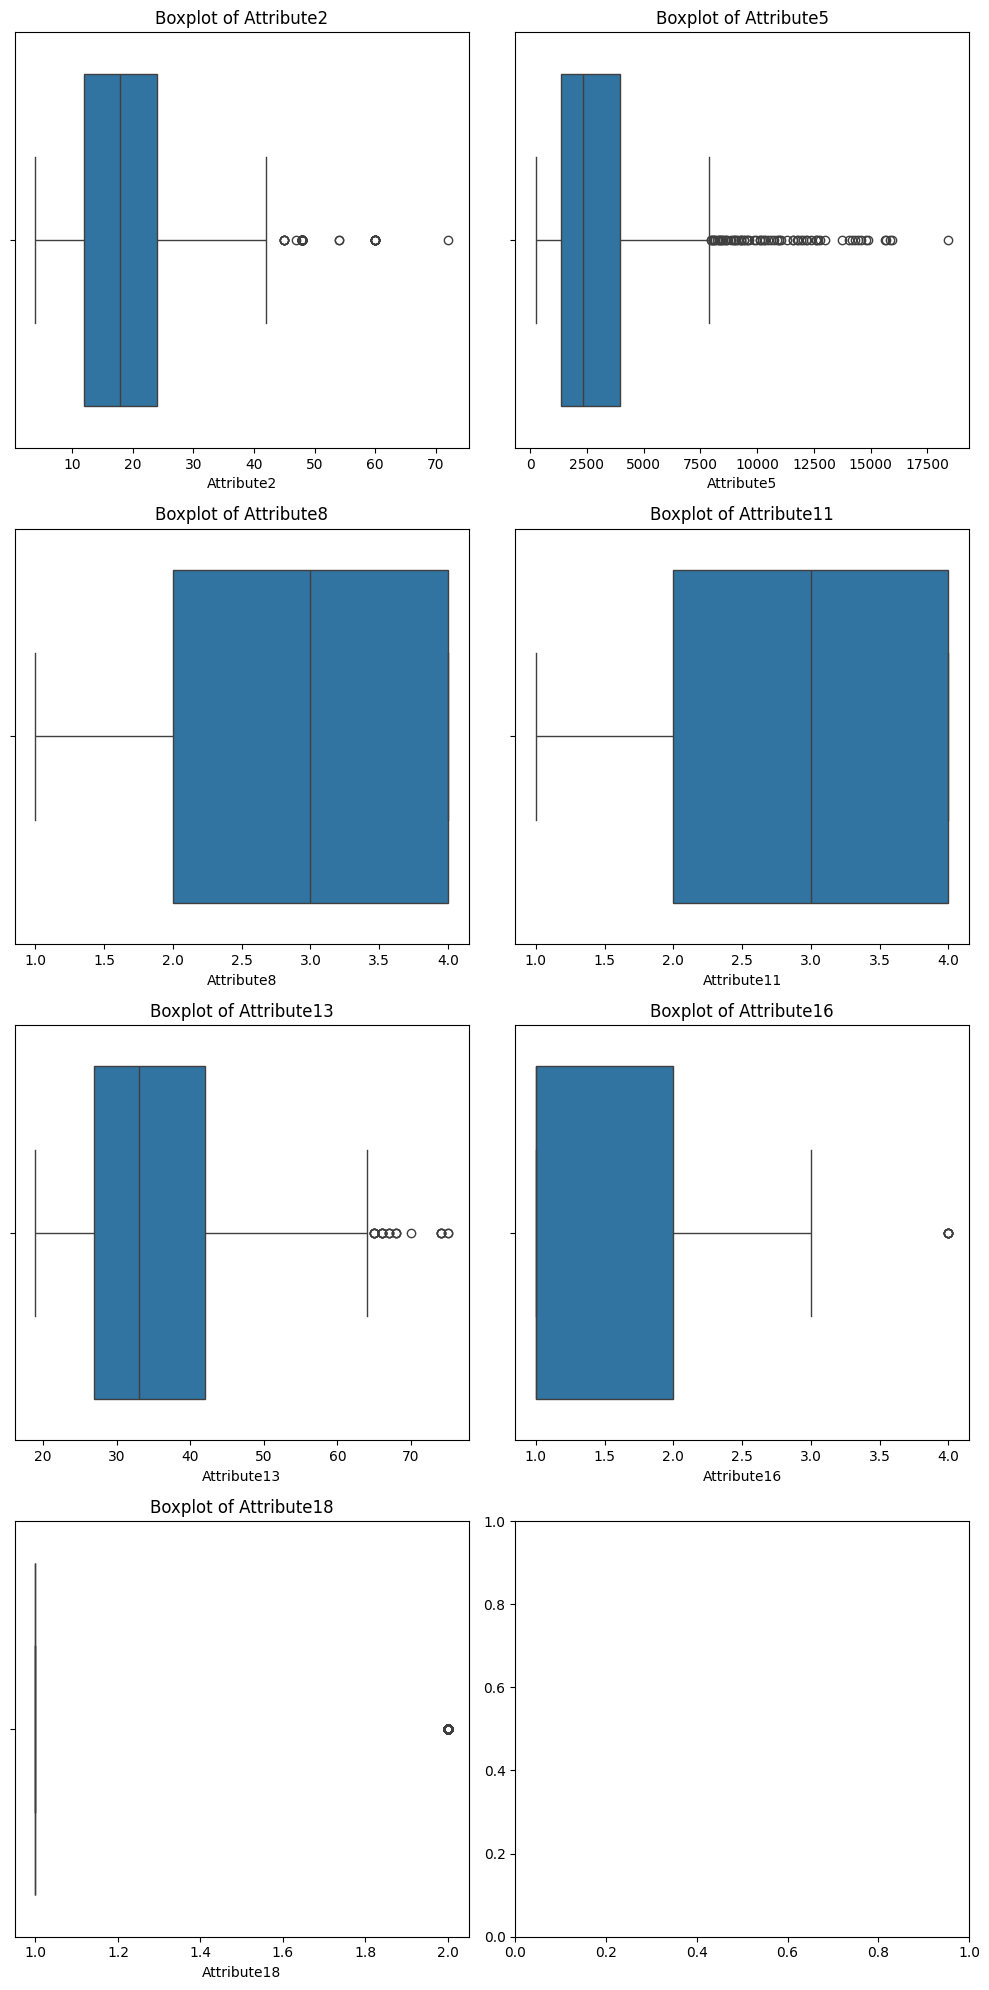

In [91]:
# numerical
numerical_attributes = variables[variables["type"] == "Integer"]["name"]
n_rows = (len(numerical_attributes) + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(10, 5 * n_rows))
axes = axes.flatten()
for i, col in enumerate(numerical_attributes):
    sns.boxplot(x=df[col], ax=axes[i])
    axes[i].set_title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

It appears we have quite a few anomalous numerical data points that may skew our results. Hence, we will treat them as outliers and remove the data points.

In [92]:
# tracking numerical outliers
for attribute in numerical_attributes:
    Q1 = df[attribute].quantile(0.25)
    Q3 = df[attribute].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    attribute_mask = (df[attribute] >= lower) & (df[attribute] <= upper)
    mask &= attribute_mask
    outliers = df[~attribute_mask]
    print(f"There were {len(outliers)} outliers for {attribute}")

There were 70 outliers for Attribute2
There were 72 outliers for Attribute5
There were 0 outliers for Attribute8
There were 0 outliers for Attribute11
There were 23 outliers for Attribute13
There were 6 outliers for Attribute16
There were 155 outliers for Attribute18


Next, we must address categorical outliers if they exist. We will detect these by looking at the frequency at which values for specific categories occur. We will use 0.01% as the threshold for which a category has to appear more than to not be considered an outlier. We will use this low threshold so that we can ensure that we consider most if not all possible attribute values, thereby allowing for all models we train to be as robust as possible when making predictions.

There were 0 outliers for Attribute1


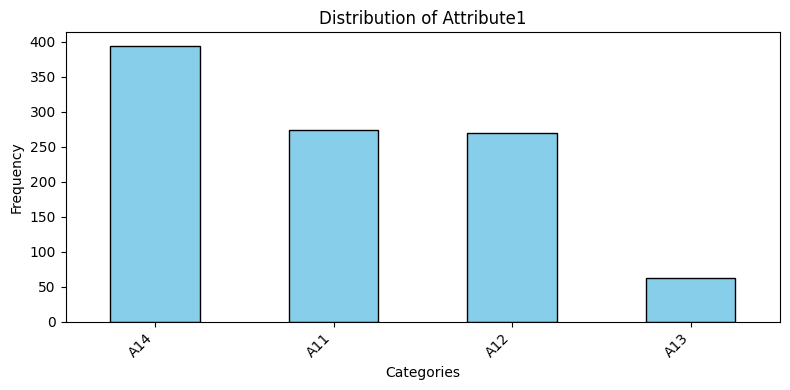

There were 0 outliers for Attribute3


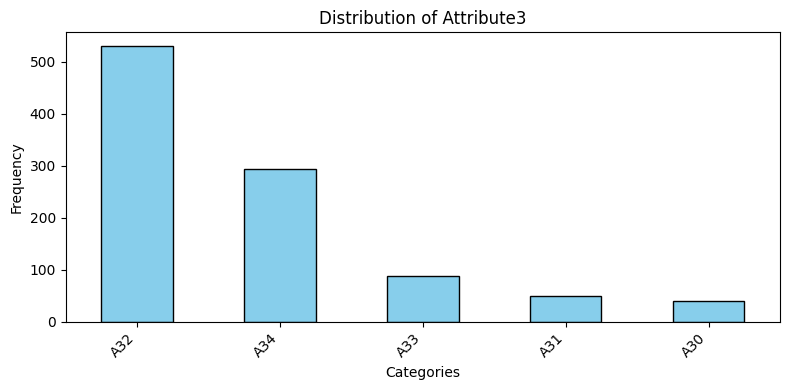

There were 0 outliers for Attribute4


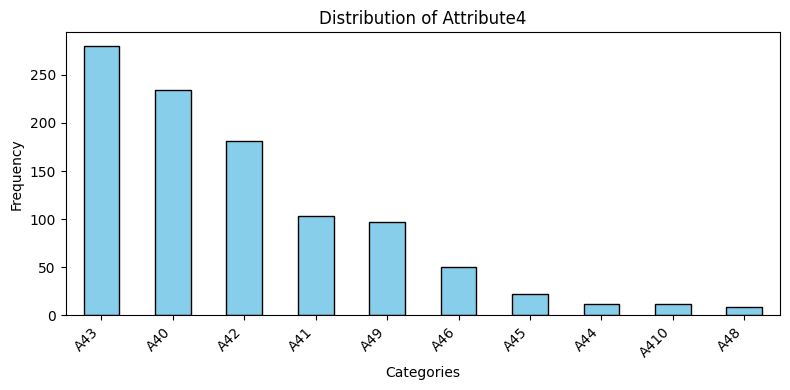

There were 0 outliers for Attribute6


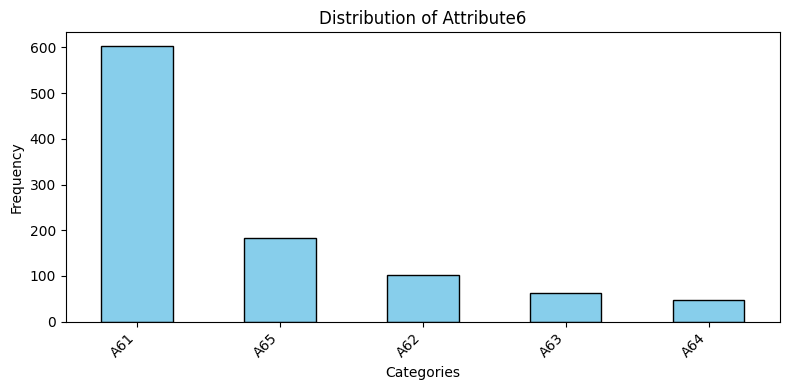

There were 0 outliers for Attribute7


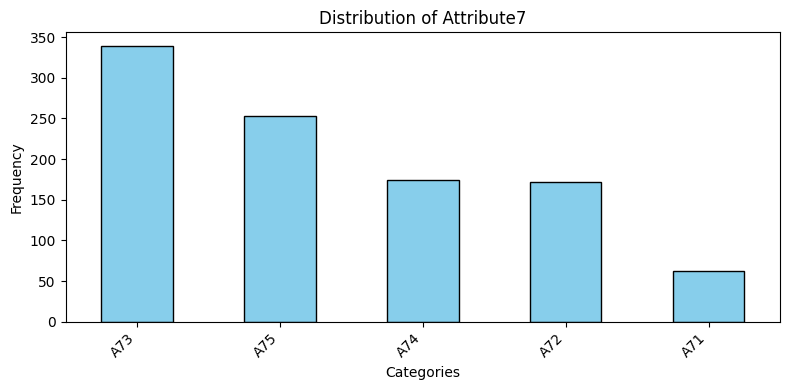

There were 0 outliers for Attribute9


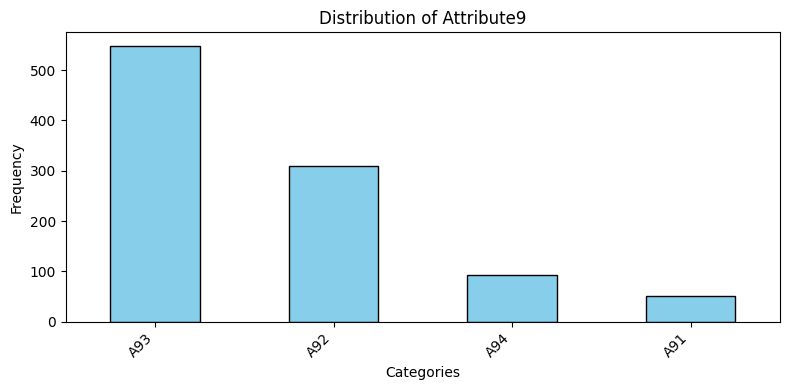

There were 0 outliers for Attribute10


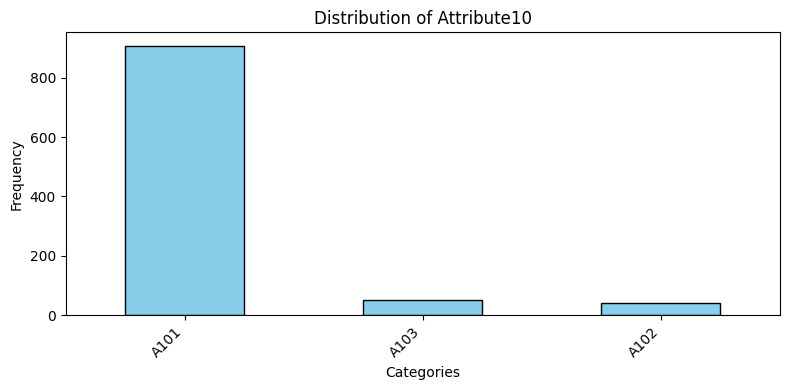

There were 0 outliers for Attribute12


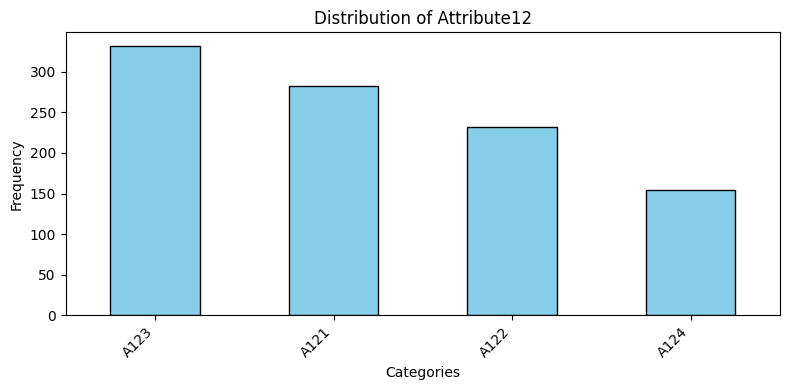

There were 0 outliers for Attribute14


In [ ]:
# categorical
categorical_attributes = variables[variables["type"].isin(["Categorical", "Binary"]) & (variables["name"] != "class")]["name"]
for attribute in categorical_attributes:
    outlierCategories = []
    value_counts = df[attribute].value_counts()
    for label, count in value_counts.items():
        if (count / len(df) <= 0.001):
            outlierCategories.append(label)
    print(f"There were {len(outlierCategories)} outliers for {attribute}")
    plt.figure(figsize=(8, 4))
    value_counts.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {attribute}")
    plt.xlabel("Categories")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [ ]:
# removing outliers
print(f"Starting DataFrame Size: {len(df)}")
df = df[mask]
print(f"Ending DataFrame Size: {len(df)}")

For this project, we will be training 3 different models:
1. Linear Model - Logistic Regression
2. Tree-Based Model - Random Forest
3. Neural Network Model

We will preprocess our data differently based on the type of model being used. For our linear and neural network models, we will rely on one-hot encoding. For our tree-based model, we will rely on label encoding. However, in order to assess the performance of different models across different folds while performing k-fold cross validation, we need to ensure we are using the same training/testing data for each model as well as applying the appropriate encoding and normalization/scaling. We will accomplish this by using pipelines.

In [ ]:
# random forest pipeline
X = df[[col for col in df.columns if col != "class"]]
y = df[["class"]].values.ravel()
# preprocessors
one_hot_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_attributes),
        ('cat', OneHotEncoder(), categorical_attributes)
    ])
ordinal_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_attributes),
        ('cat', OrdinalEncoder(), categorical_attributes)
    ])
# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('preprocessor', one_hot_preprocessor),
    ('model', LogisticRegression())
])
# random forest pipeline
rf_pipeline = Pipeline([
    ('preprocessor', ordinal_preprocessor),
    ('model', RandomForestClassifier())
])
# neural network pipeline
nn_pipeline = Pipeline([
    ('preprocessor', one_hot_preprocessor),
    ('model', MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000))
])
# cross-validate each pipeline
lr_scores = cross_val_score(lr_pipeline, X, y, cv=5, scoring='accuracy')
rf_scores = cross_val_score(rf_pipeline, X, y, cv=5, scoring='accuracy')
nn_scores = cross_val_score(nn_pipeline, X, y, cv=5, scoring='accuracy')
# evaluate
print(f"Random Forest: {rf_scores.mean()}")
print(f"Logistic Regression: {lr_scores.mean()}")
print(f"Neural Network: {nn_scores.mean()}")


## Data Cleaning
Cleaning: Handling missing values (imputation, removal), correcting inconsistencies (e.g., fixing typos), and ensuring the correct data types.

In [ ]:
for k in metadata.keys():
    print(k)

In [ ]:
for k in metadata.keys():
    print(k)

In [ ]:
for k in data.variables:
    print(k)